# Environment simulations using ODEs

Environment dynamics with agents with some understanding of how the environment
works can be simulated as a system of ordinary differential equations. Below is
an example of how to run simulations like that using `gxr.envir` package.

There are three control parameters of interest that may be modified by GuestXR
to achieve desired result - sustainable and relatively equal profit extraction.

* Time horizon in which agents try to predict consequences of their actions,
  i.e. the effects of how much resource they extract from the environment.
  This is controlled by `horizon` parameter, which defines (approximately) the
  length of the time horizon of foresight expressed in terms of the characteristic
  timescale of the environment (the amount of time it needs to regenerate from 5%
  to 95% of its carrying capacity).
  * `horizon` $\in (0, \infty)$ with the default/initial value `horizon = 0.1`
* Agents' bias towards believing that the state of the environment is better 
  (closer to the maximum carrying capacity) than it really is.
  * `bias` $\in [0, 1]$ with the default/initial value `bias = 0`
* Agents' belief that the other agents will behave similarly to us
  controlled by `alpha` parameter.
  * `alpha` $\in [0, 1]$ with the default/initial value `alpha = 0`
  
* For now the default number of agents is ``4`` as this is the planned number
  of participants in VR experiments.

**NOTE.**

All the above control parameters may be accessed as well as set and/or modified using
standard Python getters and setters.

**NOTE.**

This software runs for `python>=3.11`.

## Initializing game instance

Below is an example of how to initialize a game instance.

In [1]:
from gxr.envir import EnvirGame

game = EnvirGame.from_config()

## Core results

First, let us see some core results to see the main qualitative properties of the model.

### Time horizon

Appropriate time horizon (ability to predict consequences of one's actions)
is sufficient to achieve sustainability of a single agent.

But if the horizon is too short even a single agent may fail.

#### Short time horizon

Here we initialize and run dynamics for a single agent.
With short time horizon the agent fails, which is evident by decreasing
utility after the environment resources are consumed.

**NOTE.**

The argument passed to `dynamics.run()` is the number of "epochs" to run the simulation
for. A single epoch is a time required for the environment to regenerate from a state
of low resources (5% of the carrying capacity) to the state of abundance
(95% of the carrying capacity).

**NOTE.**

All the main parameters can be set conveniently by passing appropriately named arguments
to the `.from_config()` constructor.

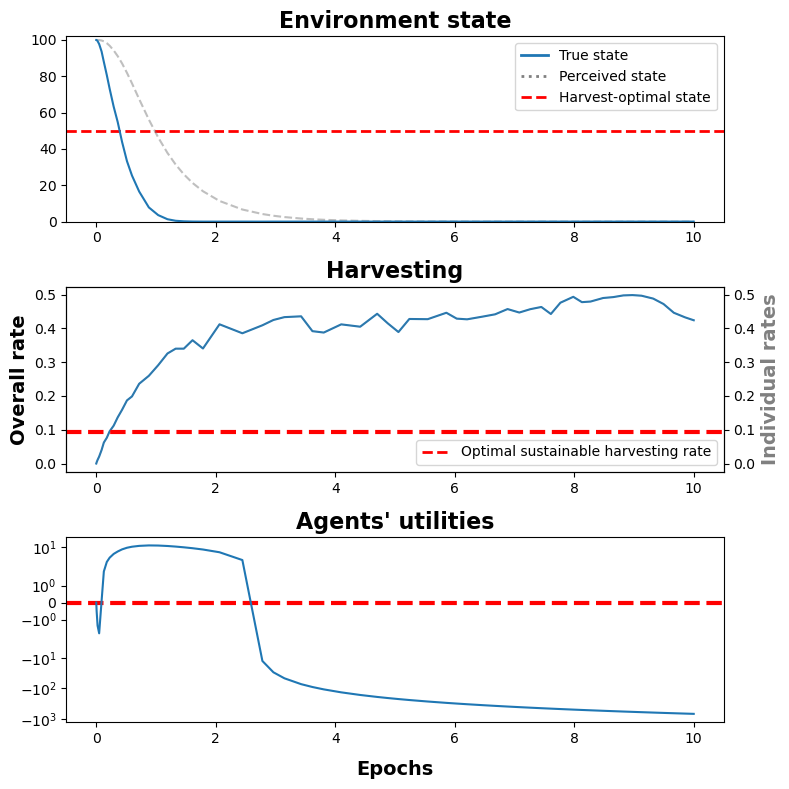

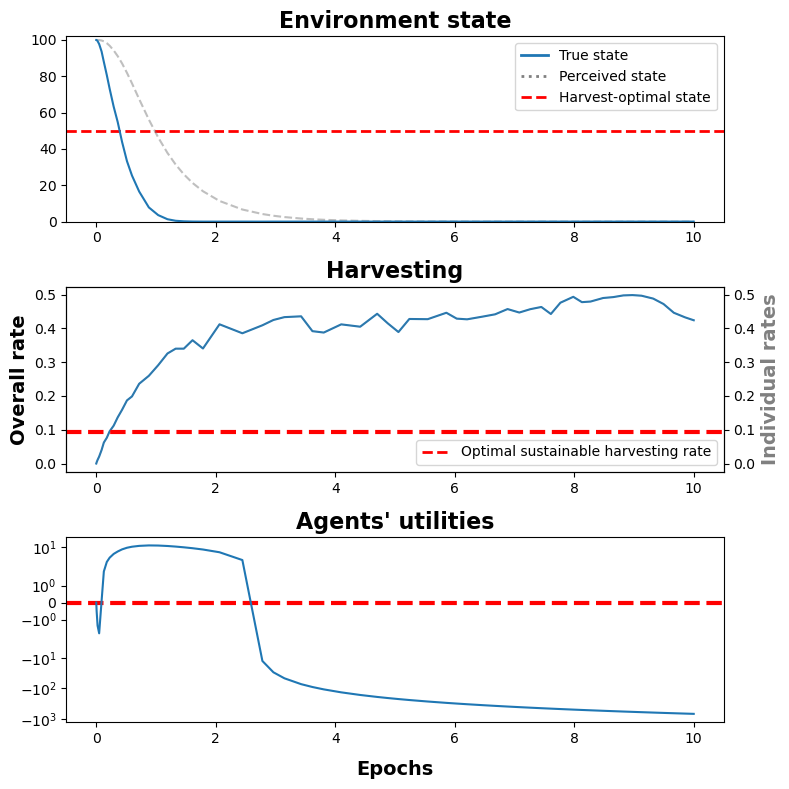

In [2]:
game = EnvirGame.from_config(n_agents=1, horizon=.1)
sol  = game.dynamics.run(10, seed=None)

fig = game.dynamics.plot(sol)
fig

## Long time horizon

With longer time horizon a single agent can succeed.

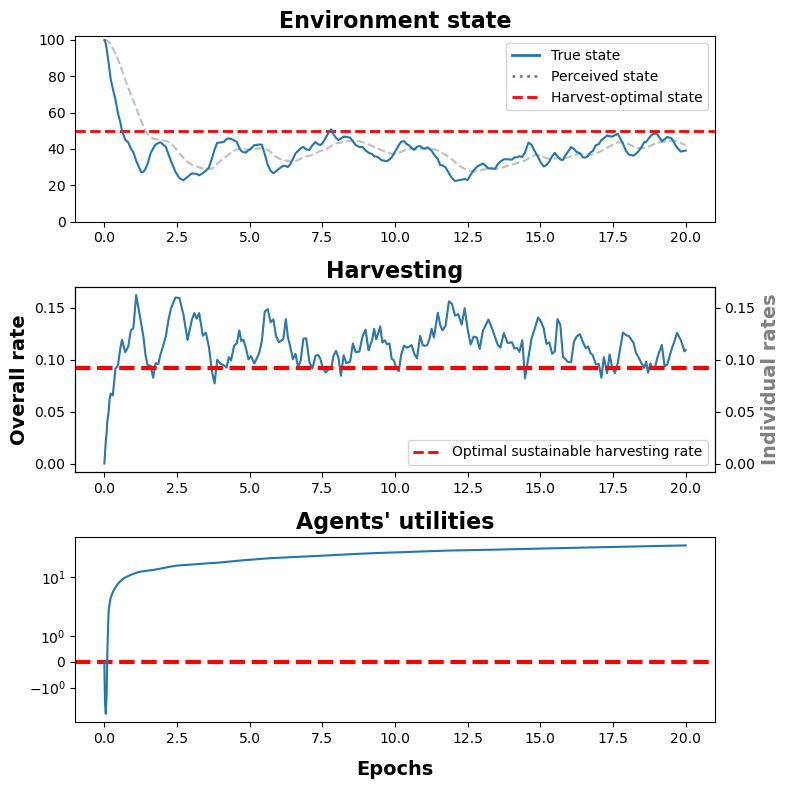

In [3]:
game = EnvirGame.from_config(n_agents=1, horizon=2)
sol  = game.dynamics.run(20, seed=304)

fig = game.dynamics.plot(sol)
fig

And in general the optimal long-term behavior will be approached as `horizon` goes to
infinity.

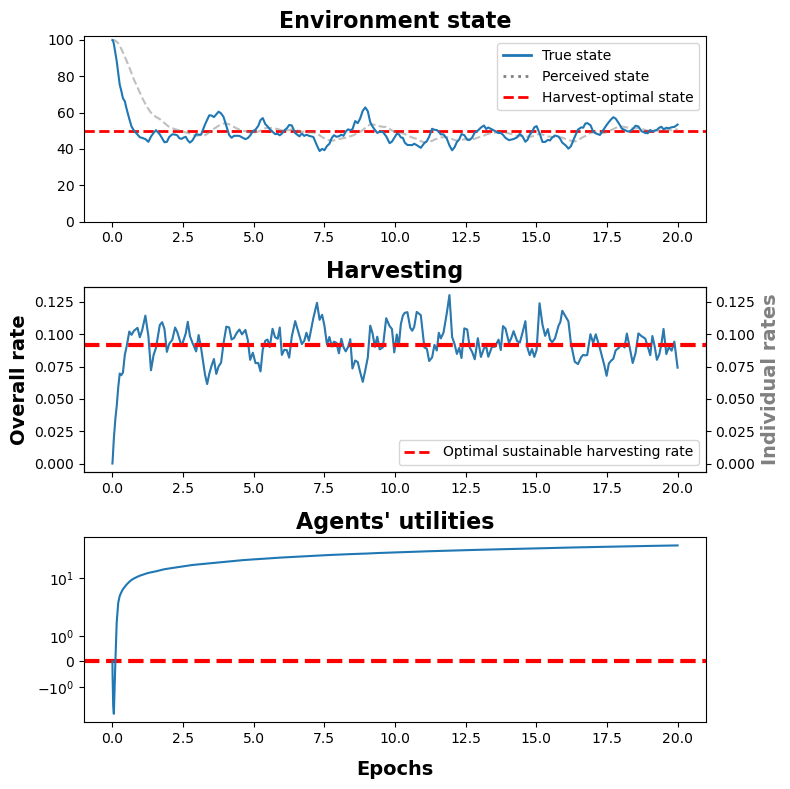

In [4]:
game = EnvirGame.from_config(n_agents=1, horizon=20)
sol  = game.dynamics.run(20, seed=305)

fig = game.dynamics.plot(sol)
fig

## Horizon is not enough in a multi-agent case

But time horizon is not enough by itself in a multi-agent case.
We can see this already in a game with 4 agents.

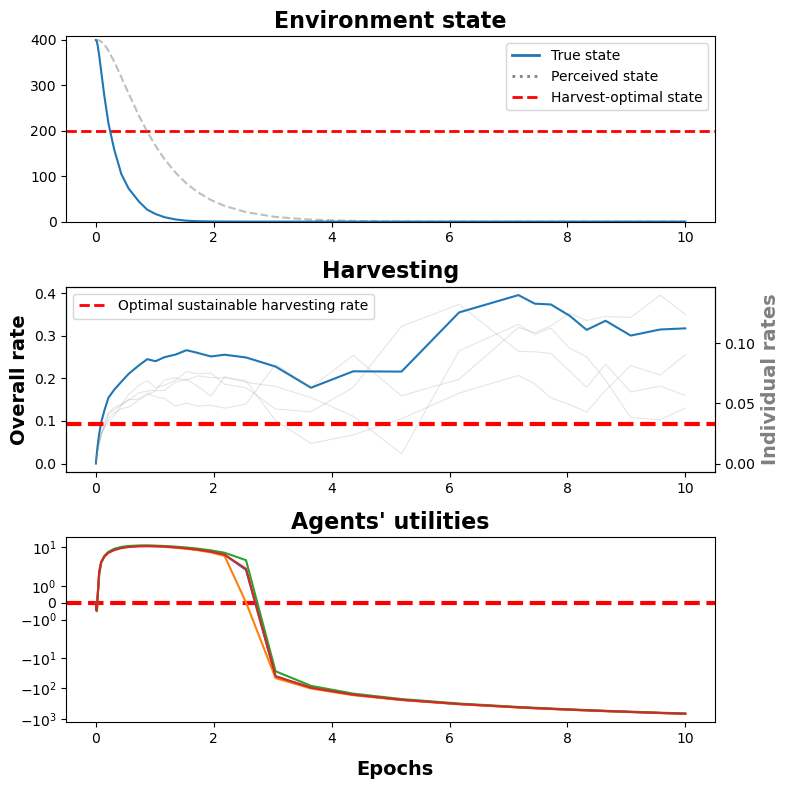

In [5]:
game = EnvirGame.from_config(n_agents=4, horizon=5)
sol  = game.dynamics.run(10, seed=305)

fig = game.dynamics.plot(sol)
fig

## Belief-coordination reduces multi-agent problem to a single-agent problem

Using the `alpha` parameter we can equip the agents with some degree of a belief
that the others will do the same as us, and this effectively reduces the multi-agent
problem to a single-agent problem which can be handled effectively with an appropriate
time horizon.

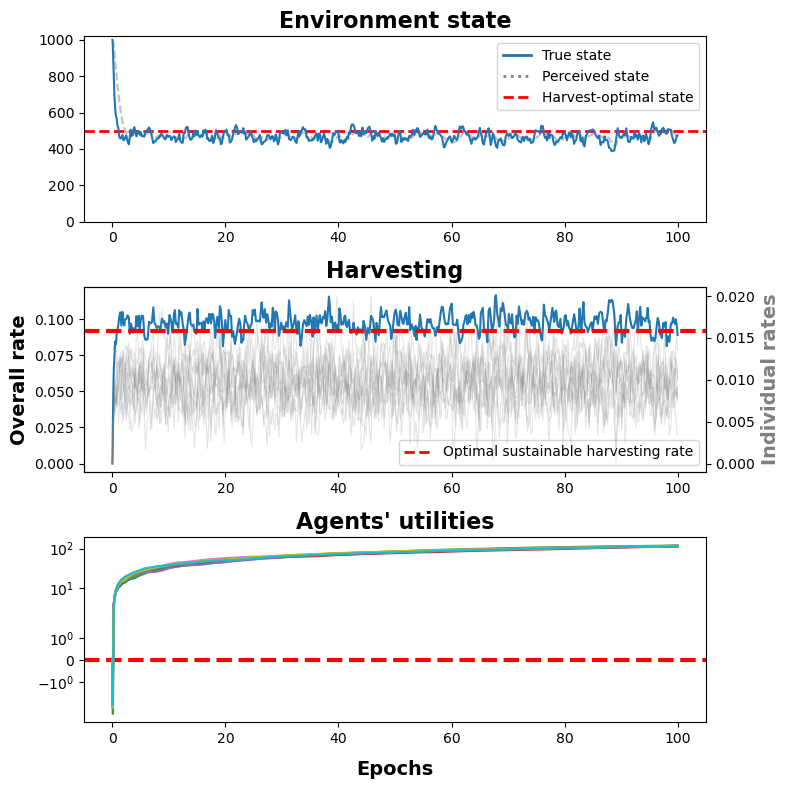

In [6]:
game = EnvirGame.from_config(n_agents=10, horizon=10, alpha=1)
sol  = game.dynamics.run(100, seed=None)

fig = game.dynamics.plot(sol)
fig

But note that this will not work if the time horizon is too short.

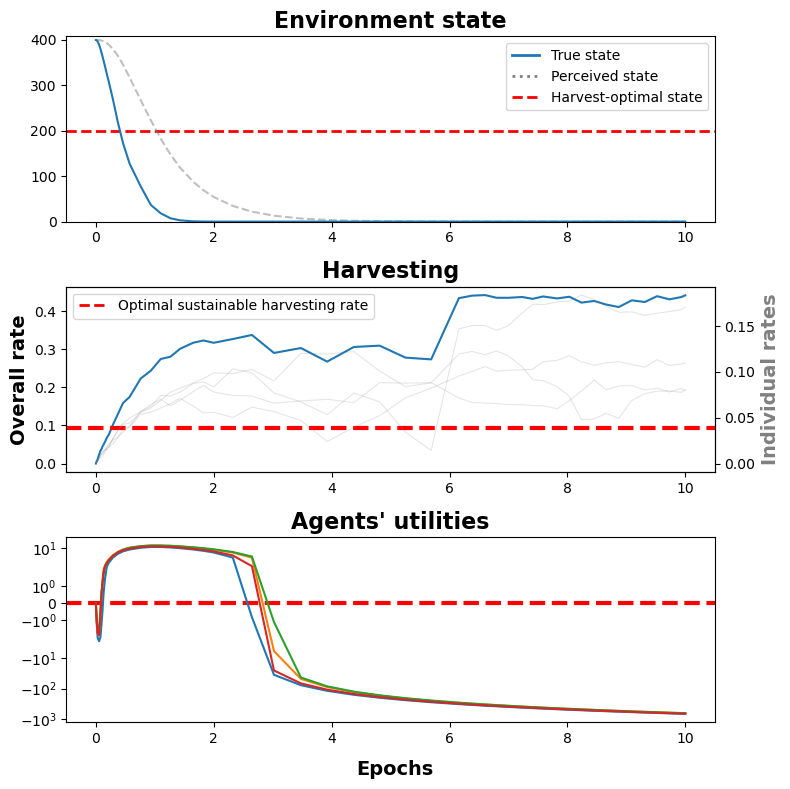

In [7]:
game = EnvirGame.from_config(n_agents=4, horizon=.1, alpha=1)
sol  = game.dynamics.run(10, seed=307)

fig = game.dynamics.plot(sol)
fig

## Effects of time delay

We do not show the effects of time delay in detail. In general, lower time delay just make it
easier to succeed by making predicting consequences easier. 